In [180]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn
import pandas as pd, numpy as np
sn.set_context('notebook')

This notebook compares three different approaches to performing **simple linear regression**:

  1. **Frequentist Ordinary Least Squares (OLS) regression**. This is just the usual approach to regression that most people are familiar with. <br><br>
  
  2. **Bayesian MCMC**. A formal Bayesian approach, exactly the same as introduced in section 7 of notebook 4. <br><br>
  
  3. **Generalised Likelihood Uncertainty Estimation (GLUE)**. An approach based on an *informal* (or pseudo-) likelihood function. GLUE is widely applied in hydrology as a conceptually simpler alternative to the formal Bayesian approach.
  
It's worth emphasising that using **numerical simulation approaches** such as Bayesian MCMC or GLUE to solve a simple linear regression problem is a case of using a very large sledgehammer ot crack a very small nut. It's is extremely unlikey that you would ever use either of these techniques for this kind of analsis in practice. However, if an approach is going to generalise well to more complex problems, it's often a good idea to check that it works for simple problems too. 

Simple linear regression is just a very basic form of parameter inference: we want to infer the **slope** and **intercept** of our regression line, subject to a particular error model. The simplest form of linear regression assumes **independent and identically distributed (iid)** Guassian erros with mean zero.

$$y = ax + b + \epsilon \qquad where \qquad \epsilon \sim \mathcal N(0, \sigma_\epsilon)$$

We will start by generating some synthetic data based on the equation above and we'll then use the three methods above to estimate the **regression parameters** and associated **confidence intervals**. The reason for doing this is to **check that the two more complicated approaches gives results that are consistent with the simple frequentist method** (which is very well-established).

## 1. Generate synthetic data

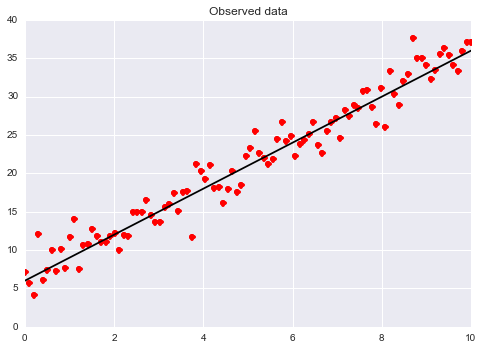

In [181]:
# Choose true params
a_true = 3
b_true = 6
sigma_true = 2
n = 100   # Length of data series

# For the independent variable, we will choose n values equally spaced
# between 0 and 10
x = np.linspace(0, 10, n)

# Calculate the true (i.e. observed) values
y = a_true*x + b_true + np.random.normal(loc=0, scale=sigma_true, size=n)

# Plot
plt.plot(x, y, 'ro')
plt.plot(x, a_true*x + b_true, 'k-')
plt.title('Observed data')
plt.show()

## 2. Frequentist linear regression

Frequentist linear regression under the assumption of iid Gaussian errors is so common that many data analysis
### 2.1. Fit model

In [182]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Add intercept for model
X = sm.add_constant(x)

# Fit
model = sm.OLS(y,X)
result = model.fit()

# Results
freq_df = pd.DataFrame(data={'a_freq':[result.conf_int()[0,0], 
                                       result.params[0], 
                                       result.conf_int()[0,1]],
                             'b_freq':[result.conf_int()[1,0], 
                                       result.params[1], 
                                       result.conf_int()[1,1]],
                             'sigma_freq':[np.nan, 
                                           (result.scale)**0.5, 
                                           np.nan]},
                       index=['2.5%', '50%', '97.5%'])
print freq_df.T

                2.5%       50%     97.5%
a_freq      5.546561  6.317710  7.088860
b_freq      2.862582  2.995813  3.129044
sigma_freq       NaN  1.957553       NaN


### 2.2. Plot result

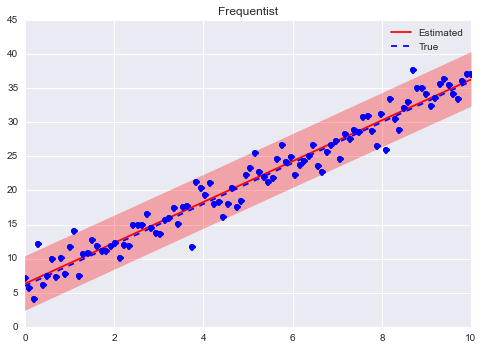

In [183]:
# Plot predicted
prstd, low, up = wls_prediction_std(result, alpha=0.05) # 95% interval
plt.fill_between(x, low, up, color='r', alpha=0.3)
plt.plot(x, result.fittedvalues, 'r-', label='Estimated')
plt.title('Frequentist')

# Plot true
plt.plot(x, y, 'bo')
plt.plot(x, a_true*x+b_true, 'b--', label='True')

plt.legend(loc='best')

### 2.3. Estimate covergage

In [184]:
# Data frame of lower CI, upper CI and observations
cov_df = pd.DataFrame({'low':low,
                       'obs':y,
                       'up':up})

# Are obs within CI?
cov_df['In_CI'] = ((cov_df['low'] < cov_df['obs']) & 
                   (cov_df['up'] > cov_df['obs']))

# Coverage
cov = 100.*cov_df['In_CI'].sum()/len(cov_df)

print 'Coverage: %.1f%%' % cov

Coverage: 95.0%


## 3. Bayesian linear regression
### 3.1. Define likelihood, prior and posterior

In [185]:
from scipy.stats import norm

def log_likelihood(params, x, obs):
    """ Calculate log likelihood assuming iid Gaussian errors.
    """    
    # Extract parameter values
    a_est, b_est, sigma_est = params
    
    # Calculate deterministic results with these parameters
    sim = a_est*x + b_est
    
    # Calculate log likelihood
    ll = np.sum(norm(sim, sigma_est).logpdf(obs))
        
    return ll

def log_prior(params):
    """ Calculate log prior.
    """   
    # Extract parameter values
    a_est, b_est, sigma_est = params
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    if ((a_min <= a_est < a_max) and 
        (b_min <= b_est < b_max) and 
        (sigma_min <= sigma_est < sigma_max)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

def log_posterior(params, x, obs):
    """ Calculate log posterior.
    """  
    # Get log prior prob
    log_pri = log_prior(params)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(params, x, obs)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

### 3.2. Define limits for uniform priors

In [186]:
a_min, a_max = -10, 10
b_min, b_max = -10, 10
sigma_min, sigma_max = 0, 10

### 3.3. Find MAP

In [187]:
from scipy import optimize

def neg_log_posterior(params, x, obs):
    """ Negative of log posterior.
    """
    return -log_posterior(params, x, obs)

def find_map(init_guess, x, obs):
    """ Find max of posterior.
        init_guess [a, b, sigma]
    """
    # Run optimiser
    param_est = optimize.fmin(neg_log_posterior, 
                              init_guess, 
                              args=(x, obs))

    return param_est

# Guess some starting values for [a, b, sigma]
param_guess = [1, 1, 1]

# Run optimiser
param_est = find_map(param_guess, x, y)

# Print results
print '\n'
for idx, param in enumerate(['a', 'b', 'sigma',]):
    print 'Estimated %s: %.2f.' % (param, param_est[idx])

Optimization terminated successfully.
         Current function value: 208.053247
         Iterations: 194
         Function evaluations: 344


Estimated a: 3.00.
Estimated b: 6.32.
Estimated sigma: 1.94.


### 3.4. Run MCMC



Average acceptance fraction:  0.675
Autocorrelation time:  [ 13.80542726  33.41382296   8.54747938]


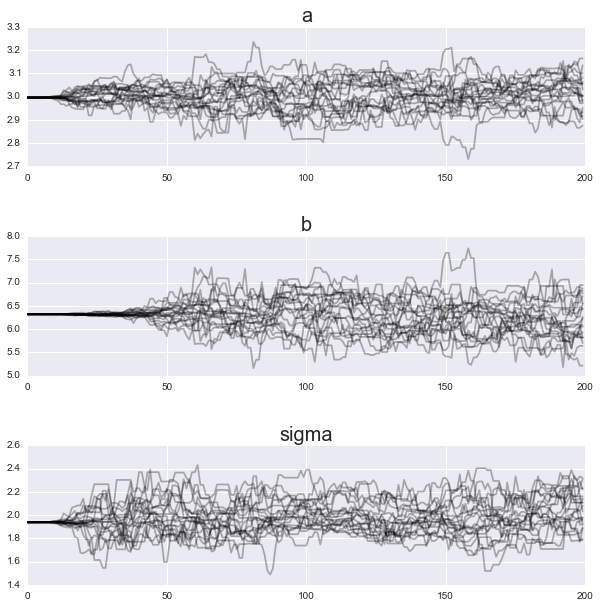

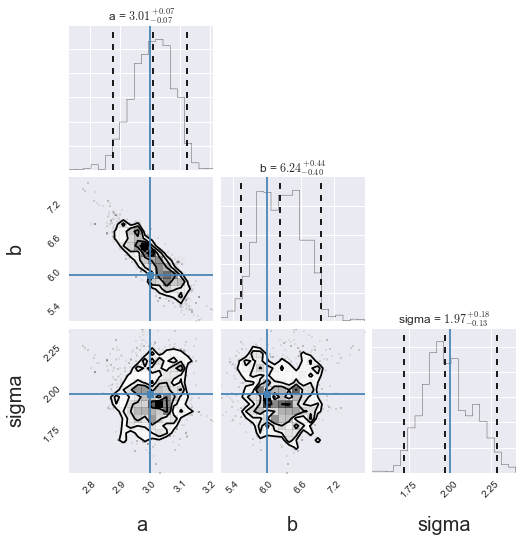

In [188]:
import emcee, corner

# emcee parameters
n_dim = 3      # Number of parameters being calibrated
n_walk = 20    # Number of "walkers"/chains
n_steps = 200  # Number of steps per chain
n_burn = 100   # Length of burn-in to discard

def run_mcmc(n_dim, n_walk, n_steps, n_burn, param_opt, truths=None):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            param_opt  Optimised parameter set from find_map()
            truths     True values (if known) for plotting
        
        Produces plots of the chains and a 'corner plot' of the
        marginal posterior distribution.
        
        Returns an array of samples (with the burn-in discarded).
    """
    # Generate starting locations for the chains by adding a small
    # amount of Gaussian noise to optimised MAP
    starting_guesses = [param_opt + 1e-4*np.random.randn(n_dim) 
                        for i in range(n_walk)]

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, 
                                    args=[x, y])

    # Run sampler
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats. based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    param_labels = ['a', 'b', 'sigma']
    fig, axes = plt.subplots(nrows=n_dim, ncols=1, figsize=(10, 10))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.subplots_adjust(hspace=0.5)    
    plt.show()

    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

    # Triangle plot
    tri = corner.corner(samples,
                        labels=param_labels,
                        truths=truths,
                        quantiles=[0.025, 0.5, 0.975],
                        show_titles=True, 
                        title_args={'fontsize': 24},
                        label_kwargs={'fontsize': 20})

    return samples

samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, param_est, 
                   [a_true, b_true, sigma_true])

### 3.6. Get confidence intervals

In [189]:
# Print estimates and confidence intervals
mcmc_df = pd.DataFrame(data=samples, columns=['a_mcmc', 'b_mcmc', 'sigma_mcmc'])
print mcmc_df.describe(percentiles=[0.025, 0.5, 0.975]).ix[['2.5%', '50%', '97.5%']].T

                2.5%       50%     97.5%
a_mcmc      2.875283  3.009646  3.121982
b_mcmc      5.536730  6.242677  6.959819
sigma_mcmc  1.718444  1.969984  2.284565


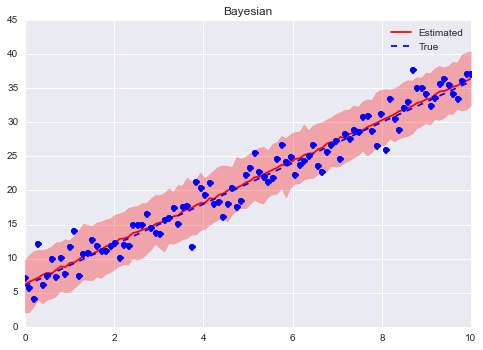

In [190]:
# Store output data in lists
conf = []

# Pick parameter sets at random from the converged chains
for a, b, sigma in samples[np.random.randint(len(samples), size=300)]:
    # Simulate values
    sim = a*x + b + norm.rvs(loc=0, scale=sigma, size=n)
    
    df = pd.DataFrame(data={'Sim':sim})
    
    # Add to conf
    conf.append(df)

# Concatenate results
conf = pd.concat(conf, axis=1)

# Get 2.5 and 97.5 percentiles for plotting
conf = conf.T.describe(percentiles=[0.025, 0.5, 0.975]).T[['2.5%', '50%', '97.5%']]

# Plot predicted
plt.fill_between(x, conf['2.5%'], conf['97.5%'], color='r', alpha=0.3)
plt.plot(x, conf['50%'], 'r-', label='Estimated')
plt.title('Bayesian')

# Plot true line
plt.plot(x, y, 'bo')
plt.plot(x, a_true*x+b_true, 'b--', label='True')

plt.legend(loc='best')

plt.show()

### 3.7. Get coverage

In [191]:
# Add observations to df
conf['obs'] = y

# Are obs within CI?
conf['In_CI'] = ((conf['2.5%'] < conf['obs']) & 
                 (conf['97.5%'] > conf['obs']))

# Coverage
cov = 100.*conf['In_CI'].sum()/len(conf)

print 'Coverage: %.1f%%' % cov

Coverage: 95.0%


## 4. GLUE
### 4.1. Define pseudo-likelihood

In [192]:
def nash_sutcliffe(params, x, obs):
    """ Nash-Sutcliffe efficiency.
    """
    # Extract parameter values
    a_est, b_est = params
    
    # Run simulation
    sim = a_est*x + b_est
    
    # NS
    num = np.sum((sim - obs)**2)
    denom = np.sum((obs - obs.mean())**2)
    ns = 1 - (num/denom)
    
    return [ns, sim]

### 4.2. Set behavioural threshold and sample size

In [193]:
ns_min = 0.7
n_samp = 4000

### 4.3. Sample from priors

In [194]:
a_s = np.random.uniform(low=a_min, high=a_max, size=n_samp)
b_s = np.random.uniform(low=b_min, high=b_max, size=n_samp)

### 4.4. Run GLUE

In [195]:
def run_glue(a_s, b_s, n_samp, ns_min):
    """ Run GLUE analysis.
    """
    # Store output
    out_params = []
    out_sims = []

    # Loop over param sets
    for idx in range(n_samp):
        params = [a_s[idx], b_s[idx]]

        # Calculate Nash-Sutcliffe
        ns, sim = nash_sutcliffe(params, x, y)

        # Store if "behavioural"
        if ns >= ns_min:
            params.append(ns)
            out_params.append(params)
            out_sims.append(sim)

    # Build df
    params_df = pd.DataFrame(data=out_params, 
                             columns=['a', 'b', 'ns'])

    assert len(params_df) > 0, 'No behavioural parameter sets found.'

    # Number of behavioural sets
    print 'Found %s behavioural sets out of %s runs.' % (len(params_df), n_samp)

    # DF of behavioural simulations
    sims_df = pd.DataFrame(data=out_sims)
    
    return params_df, sims_df

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

Found 180 behavioural sets out of 4000 runs.


### 4.5. Get confidece intervals

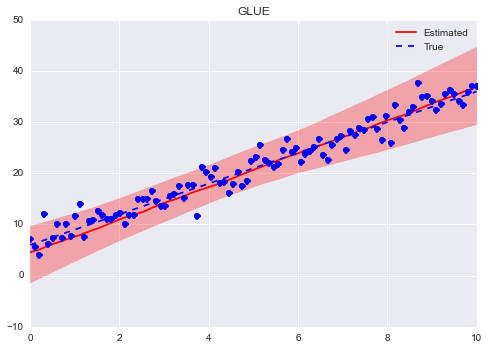

In [196]:
def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    """ From 
    http://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy     
    Very close to np.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: np.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with np.percentile.
    :return: np.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with np.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

def plot_glue(params_df, sims_df):
    """ Plot median simulation and confidence intervals for GLUE.
    """
    # Get weighted quantiles for each point in x from behavioural simulations
    weights = params_df['ns']
    quants = [0.025, 0.5, 0.975]

    # List to store output
    out = []

    # Loop over points in x
    for col in sims_df.columns:
        values = sims_df[col]
        out.append(weighted_quantile(values, quants, sample_weight=weights))

    # Build df
    glue_df = pd.DataFrame(data=out, columns=['2.5%', '50%', '97.5%'])

    # Plot predicted
    plt.fill_between(x, glue_df['2.5%'], glue_df['97.5%'], color='r', alpha=0.3)
    plt.plot(x, glue_df['50%'], 'r-', label='Estimated')
    plt.title('GLUE')

    # Plot true line
    plt.plot(x, y, 'bo')
    plt.plot(x, a_true*x+b_true, 'b--', label='True')

    plt.legend(loc='best')

    plt.show()
    
    return glue_df
    
glue_df = plot_glue(params_df, sims_df)

### 4.6. Coverage

In [197]:
def glue_coverage(glue_df):
    """ Prints coverage from GLUE analysis.
    """
    # Add observations to df
    glue_df['obs'] = y

    # Are obs within CI?
    glue_df['In_CI'] = ((glue_df['2.5%'] < glue_df['obs']) & 
                        (glue_df['97.5%'] > glue_df['obs']))

    # Coverage
    cov = 100.*glue_df['In_CI'].sum()/len(glue_df)

    print 'Coverage: %.1f%%' % cov
    
glue_coverage(glue_df)

Coverage: 95.0%


### 4.7. Change behavioural threshold

Found 505 behavioural sets out of 4000 runs.


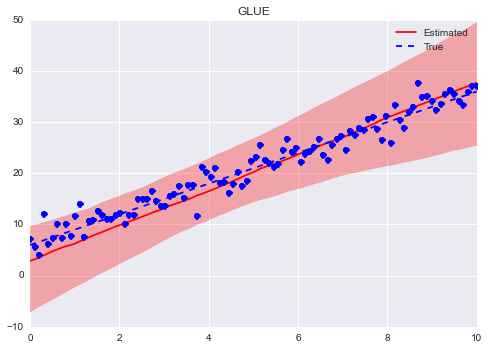

Coverage: 98.0%


In [198]:
ns_min = 0

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

glue_df = plot_glue(params_df, sims_df)

glue_coverage(glue_df)

Found 46 behavioural sets out of 4000 runs.


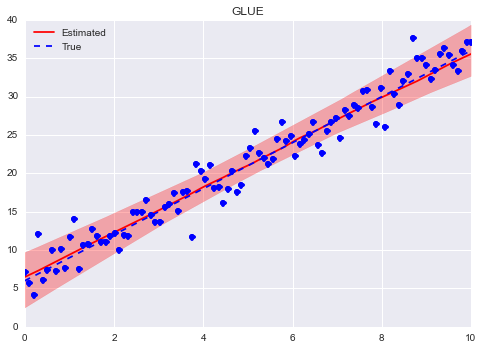

Coverage: 79.0%


In [199]:
ns_min = 0.9

params_df, sims_df = run_glue(a_s, b_s, n_samp, ns_min)

glue_df = plot_glue(params_df, sims_df)

glue_coverage(glue_df)